def ni shite yobu
https://www.mutable.work/entry/import-other-scripts

# Hugging Face Library 'Transformer'およびT5Tokenizerのダウンロード

参考(https://qiita.com/takubb/items/fd972f0ac3dba909c293)これを基に改造し、最新のGoogle Colaboratoryで動作するようにした

In [1]:
!export CUDA_LAUNCH_BLOCKING=1
!pip install transformers
!apt install swig
# Sentencepieceのインストール
!pip install sentencepiece
!pip3 install sklearn
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("rinna/japanese-roberta-base")
tokenizer.do_lower_case = True  # due to some bug of tokenizer config loading

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


# PyTorchとGPU設定

In [2]:
!pip install torch
import torch
# GPUが使えれば利用する設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# データセットの準備

ライブドアニュースコーパスをダウンロード

    ダウンロードしたファイルは圧縮（tar.gz形式）ファイル
    様々なジャンル（IT,スポーツ,家電,映画など）のWEBメディアごとにフォルダに記事がテキストファイルで保存されている
    
以下、ファイルを読み込んで、必要な部分を抽出

In [3]:
import numpy as np
import pandas as pd
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.model_selection import learning_curve
#from sklearn import linear_model
import matplotlib.pyplot as plt

import os
import re
import csv
import glob
import warnings
import numpy as np
warnings.filterwarnings('ignore')
#urllib.request.urlretrieve("https://www.rondhuit.com/download/ldcc-20140209.tar.gz", "ldcc-20140209.tar.gz")
# ダウンロードした圧縮ファイルのパスを設定
#tgz_fname = "ldcc-20140209.tar.gz" 
# 2つをニュースメディアのジャンルを選定
mydata = '/export/livedoor' 
#処理をした結果を保存するファイル名 
tsv_fname = "all_text.tsv" 

def remove_brackets(inp):
    output = re.sub(u'[〃-〿]', '',(re.sub('＝|=|×|\(|\)|“|”|（|）|／|\[|\]| |　|…|・|\n|\t|/|＜|＞|@|＠', '', re.sub(u'[ℊ-⿻]', '', inp)))) #210A ~ 2FFF
    return output

"""
def read_url(f):
    url = next(f)
    return url[:-1]

def read_date(f):
    date = next(f)
    date = remove_brackets(date.encode().decode('utf-8'))
    return date[:-1]
"""

def read_title(f):
    next(f)
    next(f)
    title = next(f)
    title = remove_brackets(title.encode().decode('utf-8'))
    return title[:-1]

def read_para(f):
    p = ''
    while True:
        try:
            para = next(f)
            para = remove_brackets(para.encode().decode('utf-8'))
            p += para
        except StopIteration:
            break
    return p [:-1]

In [4]:
directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/it-life-hack']
target_genre = ["dokujo-tsushin", "it-life-hack"] 
#directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/peachy']
#target_genre = ["dokujo-tsushin", "peachy"] 
zero_fnames = []
one_fnames = []

if os.path.exists(tsv_fname) == True:
    with open(tsv_fname, "r+") as f:
        f.truncate(0)

for i in range(2):
    for filename in os.listdir(directory[i]):
        if "LICENSE.txt" in filename:
            continue
        f = os.path.join(directory[i], filename)
        #if os.path.isfile(f):
        #    print(f)
        if target_genre[0] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[0], '0', title, para]
                    writer.writerow(row)
            continue
        if target_genre[1] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[1], '1', title, para]
                    writer.writerow(row)
            continue

pandasでデータを読み込み

In [5]:
import pandas as pd
# データの読み込み
df = pd.read_csv("all_text.tsv", 
                 delimiter='\t', header=None, names=['media_name', 'label','title','sentence'])
# データの確認
print(f'データサイズ： {df.shape}')
df.sample(10)

データサイズ： (1740, 4)


,media_name,label,title,sentence
1674,it-life-hack,1,オシャレなページで情報発信！Tumblrのデザインを設定してみよう知っ得！虎の,Tumblrの特徴の1つとして、あらかじめ用意されているブログのデザインテーマの豊富さがあげ...
133,dokujo-tsushin,0,親からまだ結婚しないの？と言われなくなる,この前親戚の集まりに行ったんですけど、前はみんな久美ちゃんまだ結婚しないの？ってうるさかった...
346,dokujo-tsushin,0,あなたのモテ期はいつやってきた,森山未來主演の映画モテキ。地味でモテなくて、恋愛に奥手の童貞男が、ある時期を境に女の子からモ...
1058,it-life-hack,1,こういうWiFi名もアリ？自作自演もある楽しいWiFiアクセスポイント,無線LAN以下便宜上WiFiと表記には、そのWiFiネットワークに接続するためのアクセスポイ...
1265,it-life-hack,1,ウェブページのイメージを丸ごと取り込むワザ知っ得虎の,会社概要に自社ウェブページのイメージを貼り付けたいとか、ブログページのイメージを丸ごと保存し...
153,dokujo-tsushin,0,自転車女子、はじめましたvol.05ペダルとギアですいすいポタリングPresentedbyゆ...,今月もこんにちは、独女の皆様。お下劣、毒舌、保健室！ドロンジョーヌ恩田です。さてさて、スポー...
1293,it-life-hack,1,iPhoneで撮った動画を仲間で共有！その場で動画を共有するテクニック知っ得！虎の,iPhoneを使えば、手軽に動画を撮影できる。プライベートシーンなら、家族やペットの撮影を楽...
1087,it-life-hack,1,iPhone動画のムダをトリミングして飽きさせない知っ得虎の,iPhone4Sを使えば、高品質な動画を手軽に撮影できる。家族旅行や友達とのパーティーなどを...
304,dokujo-tsushin,0,梅村ゆずの結婚どころじゃないんですっ！vol.7うっかりできちゃった末っ子、ゆずPresen...,こんにちは。スーパーの試食で奥さん！こっちもたべて！奥さん！って言われて、独身だけどとも言え...
162,dokujo-tsushin,0,もし独女がドラッカーのマネジメントを読んだ,経営学の父、ピーターＦドラッカーがブームだ。日本でのブームのきっかけは、岩崎夏海著もし高校野...


//文章データをsentences、ラベルデータを labelsに保存、以降この2変数だけを利用

In [6]:
mn = df.media_name.values
labels = df.label.values
titles = df.title.values
sentences = df.sentence.values

# Moji suu shitei

In [7]:
df_ = pd.read_csv("summary_set_dokujo_it.tsv", delimiter='\t', header=None, names=['summaries'])
#df_ = pd.read_csv("summary_set_dokujo_peachy.tsv", delimiter='\t', header=None, names=['summaries'])

df_.sample(10)

,summaries
155,思いも寄らない「Brightキスkissキス」という DVDが話題になっている。
312,ジブリアニメの名作「おもひでぽろぼろ」が5年ぶりに公開され、多くのファンがファンに衝撃を与え...
775,思いがけない初対面の女性は、誰よりも魅力的に感じる。
1603,パソコンやタブレット端末でネット接続が容易なことは長年の問題となっており、インターネット接続...
1129,米アップルは11日、米Macの最新版の携帯端末「OSX」を正式に発表した。
547,俳優安部沙沙さんの30代独女は、90代後半から40代半ばまで90代の後半まで。
1366,日本のロックバンド「ハロープロジェクト」が歌った「幸せの途中」合体バージョンが話題になっている。
49,思いがけない話、理解の深まる話。
163,思いがけない話、理解の深まる話。
1267,カルロス・エドワース・ジョンソン氏は「超社長PCを超えるPC」と名付けられた。


In [8]:
wcount = []

for summaries in df_['summaries']:
    wcount.append(len(summaries))

In [9]:
'''
# wcount moji me kara kesu

for i in enumerate(sentences):
    if len(i[1])>wcount[i[0]]:
        sentences[i[0]] = sentences[i[0]][:wcount[i[0]]]
        
# ushiro kara wcount moji toru

for i in enumerate(sentences):
    if len(i[1])>wcount[i[0]]:
        sentences[i[0]] = sentences[i[0]][-wcount[i[0]]:]
#'''

In [10]:
print(sentences)

['す。関連サイトnifty電話占いメール占い翔生先生プロフィー'
 'これまで手つかずのお宝級の男性がいるかもしれない！今日からアイドル好きを公言してみる？パンチ広' 'に立つと信じよう。オフィスエムツー佐枝せつ'
 ... '21+3205MPキヤノン販売元：Amazon.co.jpクチコミを見' 'bowAppsRainbowAppsの記事をもっと読'
 '！キヤノン、ADF搭載小型スキャナーの魅力をさぐるTranscend400倍速CFカード32GB永久保証TS32GCF400クチコミを見']


# BERT Tokenizerを用いて単語分割・IDへ変換
## Tokenizerの準備
単語分割とIDへ変換

# テスト実行

In [11]:
# 元文章
print(' Original: ', sentences[0])
# Tokenizer
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
# Token-id
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  す。関連サイトnifty電話占いメール占い翔生先生プロフィー
Tokenized:  ['▁', 'す', '。', '関連', 'サイト', 'ni', 'f', 'ty', '電話', '占い', 'メール', '占い', '翔', '生', '先生', 'プロ', 'フィー']
Token IDs:  [9, 263, 8, 1617, 1487, 3570, 210, 5432, 2454, 21227, 3675, 21227, 8288, 196, 7016, 449, 3815]


In [12]:
# 最大単語数の確認
max_len = []
# 1文づつ処理
for sent in sentences:
    # Tokenizeで分割
    token_words = tokenizer.tokenize(sent)
    # 文章数を取得してリストへ格納
    max_len.append(len(token_words))
# 最大の値を確認
print('最大単語数: ', max(max_len))
print('上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数')

最大単語数:  83
上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数


In [13]:
input_ids = []
attention_masks = []

# 1文づつ処理
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = 80,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                        truncation=True,                
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )
    
    # https://qiita.com/YuiKasuga/items/343309257da1798c1b63

    # 単語IDを取得    
    input_ids.append(encoded_dict['input_ids'])

    # Attention　maskの取得
    attention_masks.append(encoded_dict['attention_mask'])

# リストに入ったtensorを縦方向（dim=0）へ結合
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# tenosor型に変換
labels = torch.tensor(labels)

# 確認
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  す。関連サイトnifty電話占いメール占い翔生先生プロフィー
Token IDs: tensor([    9,   263,     8,  1617,  1487,  3570,   210,  5432,  2454, 21227,
         3675, 21227,  8288,   196,  7016,   449,  3815,     2,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3])


In [14]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# データセットクラスの作成
dataset = TensorDataset(input_ids, attention_masks, labels)

# 90%地点のIDを取得
#train_size = int(0.9 * len(dataset))
#val_size = len(dataset) - train_size
train_size = 50
val_size = len(dataset) - train_size

# データセットを分割
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('訓練データ数：{}'.format(train_size))
print('検証データ数:　{} '.format(val_size))

# データローダーの作成
batch_size = 32

# 訓練データローダー
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # ランダムにデータを取得してバッチ化
            batch_size = batch_size
        )

# 検証データローダー
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )

len(validation_dataloader)

訓練データ数：1566
検証データ数:　174 


6

In [15]:
len(next(iter(validation_dataloader))[2])

32

# tabun kokokara


In [16]:
from transformers import BertForSequenceClassification,AdamW,BertConfig

# BertForSequenceClassification 学習済みモデルのロード
model = BertForSequenceClassification.from_pretrained(
    "cl-tohoku/bert-base-japanese-whole-word-masking", # 日本語Pre trainedモデルの指定
    num_labels = 2, # ラベル数（今回はBinayなので2、数値を増やせばマルチラベルも対応可）
    output_attentions = False, # アテンションベクトルを出力するか
    output_hidden_states = False, # 隠れ層を出力するか
)

# モデルをGPUへ転送
model.cuda()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [17]:
# 最適化手法の設定
optimizer = AdamW(model.parameters(), lr=2e-5)

# 訓練パートの定義
def train(model):
    model.train() # 訓練モードで実行
    train_loss = 0
    for batch in train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    return train_loss

# テストパートの定義
def validation(model):
    model.eval()# 訓練モードをオフ
    val_loss = 0
    with torch.no_grad(): # 勾配を計算しない
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            val_loss += loss.item()
    return val_loss

In [18]:
# 学習の実行
max_epoch = 10
train_loss_ = []
test_loss_ = []

for epoch in range(max_epoch):
    train_ = train(model)
    test_ = train(model)
    train_loss_.append(train_)
    test_loss_.append(test_)

In [19]:
import statistics

#correct = 0
test_accuracy = []

# 検証方法の確認（1バッチ分で計算ロジックに確認）

model.eval()# 訓練モードをオフ
for batch in validation_dataloader:
    #print(batch)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    #print(len(b_labels))
    with torch.no_grad():   
        # 学習済みモデルによる予測結果をpredsで取得     
        preds = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        
        test_accuracy.append((torch.argmax(preds[0], 1) == b_labels).sum().item() / len(b_labels))

        #print('preds: ', torch.argmax(preds[0], 1))
        #print('b_labels: ', b_labels)
'''
        if preds == b_labels:
            correct += 1
            #test_accuracy += torch.sum(preds == b_labels).item() / len(b_labels)

#test_accuracy = correct/len(b_labels)
print(correct)
'''
print(statistics.mean(test_accuracy))


0.9293154761904762


In [20]:
a = torch.randn(4, 4)
print(a)
print(torch.argmax(a))

tensor([[ 0.2969,  1.0131,  1.3335, -0.5383],
        [-0.3333,  1.6272, -1.6146, -0.3739],
        [ 0.6714,  0.2461, -0.9107,  2.1237],
        [-0.8915, -0.8441, -1.3508,  0.0338]])
tensor(11)


In [21]:
# 予測結果の確認
print(f'出力:{preds}')

出力:SequenceClassifierOutput(loss=None, logits=tensor([[ 5.8568, -5.4320],
        [-5.9004,  5.5110],
        [-5.1885,  4.8728],
        [ 5.7132, -5.3243],
        [ 0.7045, -0.3465],
        [-5.8578,  5.4936],
        [-4.5622,  4.3357],
        [ 5.3227, -5.0509],
        [-3.3675,  3.4568],
        [-5.9306,  5.4950],
        [ 5.7092, -5.4064],
        [-5.8648,  5.4957],
        [ 5.5918, -5.2367],
        [ 5.4202, -5.0975]], device='cuda:0'), hidden_states=None, attentions=None)


In [22]:
# 比較しやすい様にpd.dataframeへ整形
import numpy as np
# pd.dataframeへ変換（GPUに乗っているTensorはgpu->cpu->numpy->dataframeと変換）
logits_df = pd.DataFrame(preds[0].cpu().numpy(), columns=['logit_0', 'logit_1'])
## np.argmaxで大き方の値を取得
pred_df = pd.DataFrame(np.argmax(preds[0].cpu().numpy(), axis=1), columns=['pred_label'])
label_df = pd.DataFrame(b_labels.cpu().numpy(), columns=['true_label'])
accuracy_df = pd.concat([logits_df, pred_df, label_df], axis=1)
accuracy_df.head()

,logit_0,logit_1,pred_label,true_label
0,5.856756,-5.431996,0,0
1,-5.900449,5.510957,1,1
2,-5.188482,4.872788,1,1
3,5.713247,-5.324265,0,0
4,0.704467,-0.346547,0,0


In [23]:
'''
correct = 0
test_accuracy = 0

p_list = []
l_list = []

p_list = pred_df.values.tolist()
l_list = label_df.values.tolist()

#print(type(pred_df))

for i in range(len(b_labels)):
    if(p_list[i] == l_list[i]):
        correct += 1

test_accuracy = correct/len(b_labels)

print(test_accuracy)
'''

'\ncorrect = 0\ntest_accuracy = 0\n\np_list = []\nl_list = []\n\np_list = pred_df.values.tolist()\nl_list = label_df.values.tolist()\n\n#print(type(pred_df))\n\nfor i in range(len(b_labels)):\n    if(p_list[i] == l_list[i]):\n        correct += 1\n\ntest_accuracy = correct/len(b_labels)\n\nprint(test_accuracy)\n'

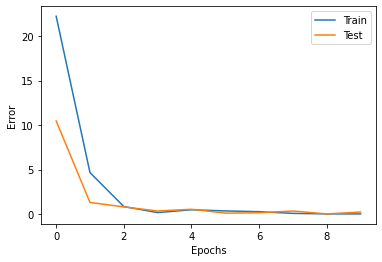

In [24]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_)), train_loss_, label="Train")
plt.plot(range(len(test_loss_)), test_loss_, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()  # ラベルがあるときは、きちんとplt.show()を呼び出すこと